# Timing the SXDS run

In this notebook we will investigate timing and requirements for the SXDS prototype run in order to estimate total computing requirements

we wil work with the file generated on iris by the following command:

```
gstatement -p IRIS-IP005-CPU -u ir-shir1 -s "2020-07-04-00:00:00" -e "2020-10-21-00:00:00" > jobs.lis
```

In [2]:
# What version of the Stack are we using?
! eups list -s | grep lsst_distrib
! eups list -s | grep obs_vista

lsst_distrib          g2d4714e03a+6e1aa0b536 	current w_2022_07 w_latest setup
obs_vista             23.0.0-1   	current setup


In [23]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [4]:
t = Table.read('./slurm/jobs_20220217.lis', format='ascii') #, data_start=2, delimiter=' ')

In [5]:
"I have submitted a total of {} jobs consuming a total of {} cpuhours".format(len(t), np.sum(t['CompHrs']))

'I have submitted a total of 701480 jobs consuming a total of 1225031.9 cpuhours'

In [6]:
t[:5]

JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs
str12,str8,str10,str10,str10,str19,str5,str10,float64
25933230,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-13T16:18:36,127:0,FAILED,0.1
25940256,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T00:08:41,1:0,FAILED,74.2
25948528,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T14:34:59,0:0,COMPLETED,254.3
26005193,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-16T03:59:49,0:0,TIMEOUT,640.0
26027949,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-17T10:46:53,0:0,TIMEOUT,1536.4


In [7]:
t[-5:]

JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs
str12,str8,str10,str10,str10,str19,str5,str10,float64
55293868_9,ir-shir1,iris-ip00+,VIDproces+,cclake,2022-02-15T16:04:52,1:0,FAILED,0.0
55293868_10,ir-shir1,iris-ip00+,VIDproces+,cclake,2022-02-15T16:04:52,1:0,FAILED,0.0
55300357,ir-shir1,iris-ip00+,vidSingFr+,cclake,2022-02-16T06:09:35,0:0,TIMEOUT,672.4
55303059_0,ir-shir1,iris-ip00+,VIDproces+,cclake,2022-02-16T11:09:47,0:0,CANCELLED+,15.9
55318689,ir-shir1,iris-ip00+,vidSingFr+,cclake,2022-02-17T00:27:42,0:0,TIMEOUT,672.3


In [8]:
len(t)

701480

In [9]:
for j in np.unique(t['JobName']):
    if 'VID' in j:
        print(j)

VIDEOTest
VID_INGEST
VIDcoadd
VIDphotop+
VIDproces+


In [10]:
def nameToJobType(name):
    """Take the name and return the tipe of pipetask"""
    job_type = 'UNKNOWN'
    if name.startswith('VIDproc'):
        job_type = 'processCcd'
    if name.startswith('VIDcoadd'):
        job_type = 'coadd'
    if name.startswith('VIDphot'):
        job_type = 'photoPipe'
    return job_type
t['job_type']  = [nameToJobType(n) for n in t['JobName']]

In [11]:
t[:5]

JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs,job_type
str12,str8,str10,str10,str10,str19,str5,str10,float64,str10
25933230,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-13T16:18:36,127:0,FAILED,0.1,UNKNOWN
25940256,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T00:08:41,1:0,FAILED,74.2,UNKNOWN
25948528,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T14:34:59,0:0,COMPLETED,254.3,UNKNOWN
26005193,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-16T03:59:49,0:0,TIMEOUT,640.0,UNKNOWN
26027949,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-17T10:46:53,0:0,TIMEOUT,1536.4,UNKNOWN


In [12]:
print("""processCcd jobs run on stack images in SXDS

Total number of jobs: {}
Jobs completed: {}
mean per job: {} cpu hours
mean per completed job: {} cpu hours
Total time: {} cpu hours
Total time on completed jobs: {} cpu hours
""".format(
np.sum(t['job_type'] == 'processCcd'),
np.sum((t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ),
np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') ]),
np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ]),
np.sum(t['CompHrs'][(t['job_type'] == 'processCcd') ]),
np.sum(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
)
)


processCcd jobs run on stack images in SXDS

Total number of jobs: 30522
Jobs completed: 15120
mean per job: 0.9617325208046655 cpu hours
mean per completed job: 1.8170039682539683 cpu hours
Total time: 29354.0 cpu hours
Total time on completed jobs: 27473.1 cpu hours



In [13]:
print("""coadd jobs run on stack images in SXDS

Total number of jobs: {}
Jobs completed: {}
mean per job: {} cpu hours
mean per completed job: {} cpu hours
Total time: {} cpu hours
Total time on completed jobs: {} cpu hours
""".format(
np.sum(t['job_type'] == 'coadd'),
np.sum((t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ),
np.mean(t['CompHrs'][(t['job_type'] == 'coadd') ]),
np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ]),
np.sum(t['CompHrs'][(t['job_type'] == 'coadd') ]),
np.sum(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
)
)

coadd jobs run on stack images in SXDS

Total number of jobs: 1109
Jobs completed: 1058
mean per job: 50.3307484220018 cpu hours
mean per completed job: 52.707844990548196 cpu hours
Total time: 55816.799999999996 cpu hours
Total time on completed jobs: 55764.899999999994 cpu hours



In [14]:
#It is worrying that these times are close to the 36 hour maximum. Can I split them up?

In [15]:
#Most of these are failures from memory shortages at teh coadd stage before I separated them
print("""photoPipe jobs run on stack images in SXDS

Total number of jobs: {}
Jobs completed: {}
mean per job: {} cpu hours
mean per completed job: {} cpu hours
Total time: {} cpu hours
Total time on completed jobs: {} cpu hours
""".format(
np.sum(t['job_type'] == 'photoPipe'),
np.sum((t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ),
np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') ]),
np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ]),
np.sum(t['CompHrs'][(t['job_type'] == 'photoPipe') ]),
np.sum(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])
)
)

photoPipe jobs run on stack images in SXDS

Total number of jobs: 4161
Jobs completed: 2073
mean per job: 43.43028118240807 cpu hours
mean per completed job: 51.39445248432224 cpu hours
Total time: 180713.4 cpu hours
Total time on completed jobs: 106540.7 cpu hours



In [16]:
np.max(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

1132.8

In [17]:
t[(t['job_type']=='coadd') & (t['State'] == 'FAILED')][:5]

JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs,job_type
str12,str8,str10,str10,str10,str19,str5,str10,float64,str10
38813235_30,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T11:22:49,1:0,FAILED,0.2,coadd
38813235_31,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T11:22:49,1:0,FAILED,0.2,coadd
38813235_32,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T11:22:49,1:0,FAILED,0.2,coadd
38813235_73,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T11:50:10,2:0,FAILED,0.2,coadd
38813235_184,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T12:28:30,2:0,FAILED,0.2,coadd


In [18]:
np.unique(t[(t['job_type']=='coadd') & (t['State'] == 'FAILED')]['ExitCode'])

1:0
2:0


In [19]:
t[(t['job_type']=='coadd') ][:5]

JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs,job_type
str12,str8,str10,str10,str10,str19,str5,str10,float64,str10
38813235_0,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T17:52:54,0:0,COMPLETED,69.3,coadd
38813235_1,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T17:15:43,0:0,COMPLETED,63.1,coadd
38813235_2,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T14:27:23,0:0,COMPLETED,35.0,coadd
38813235_3,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T17:12:01,0:0,COMPLETED,62.5,coadd
38813235_4,ir-shir1,iris-ip00+,VIDcoadd,skylake-h+,2021-04-27T13:54:51,0:0,COMPLETED,29.6,coadd


# 2 Calculate total times

Lets calculate some broad estimates for the main runs we will go on to perform

## 2.1 SXDS VIDEO run

This is the run used for the timing tests.

In [20]:
mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

def timing_summary(n_images,n_patches,vista_bands,tot_bands,name):
    print("""
{} summary
Full processing of input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patches: {} cpu hours
""".format(name,
    round(n_images * mean_processCcd),
    round(n_patches* mean_coadd),
    round(n_patches*mean_photo),
    n_images, n_patches,
    round(
        n_images * mean_processCcd 
        + n_patches* mean_coadd
        + n_patches* mean_photo
        )
    ))

In [21]:
n_video_sxds_images = 5263 # From ./1_SLurm_factory.ipynb
n_video_sxds_patches = 219 # From ./1_SLurm_factory.ipynb

timing_summary(n_video_sxds_images,n_video_sxds_patches,5,10,'VIDEO')


VIDEO summary
Full processing of input images: 9563 cpu hours
Full coadd of all patches: 11543 cpu hours
Full photometry pipeline on all patches: 11255 cpu hours
Total time for 5263 images and 219 patches: 32361 cpu hours



In [24]:
vid=Table.read('../../dmu1/data/video_images_overview_20210331.csv')
n_vid=np.sum([s['file'].endswith('st.fit') for s in vid])
vid_tiles=Table.read('../../dmu1/data/video_tiles_tracts_patches_overview_20200820.csv')
vid_tracts=set()
for i in vid_tiles['tract_patch_json']:
    vid_tracts=vid_tracts.union(set(json.loads(i).keys()))
n_vid_tracts=len(vid_tracts)
"VIDEO: images: {}, tracts: {}".format(n_vid,n_vid_tracts)

'VIDEO: images: 13476, tracts: 18'

In [25]:
timing_summary(n_vid,n_vid_tracts*81,5,10,'VIDEO All 3 fields')


VIDEO All 3 fields summary
Full processing of input images: 24486 cpu hours
Full coadd of all patches: 76848 cpu hours
Full photometry pipeline on all patches: 74933 cpu hours
Total time for 13476 images and 1458 patches: 176267 cpu hours



## 2.2 VHS XMM run

Run over full overlap of VHS and HSC PDR2 XMM field

In [44]:
n_vhs_xmm_images = 2100 # From ../dmu4_XMM/1_Slurm_factory.ipynb - w02_images_job_dict_2100.json
n_vhs_xmm_patches = 3996 #../dmu4_VHS/slurm/w02_patch_job_dict_3996.json

timing_summary(n_vhs_xmm_images,n_vhs_xmm_patches,3,3+5,'VHS XMM field')


VHS XMM field summary
Full processing of input images: 3816 cpu hours
Full coadd of all patches: 210621 cpu hours
Full photometry pipeline on all patches: 205372 cpu hours
Total time for 2100 images and 3996 patches: 419808 cpu hours



## 2.3 VHS PDR2 run

In [46]:
#from json files in  ../dmu4_VHS/slurm
n_vhs_pdr2_images=7174 #../dmu4_VHS/slurm/full_images_job_dict_7174.json
n_vhs_pdr2_patches=13164 #../dmu4_VHS/slurm/full_patch_job_dict_13164.json
timing_summary(n_vhs_pdr2_images,n_vhs_pdr2_patches,3,3+5,'VHS full Sky')


VHS full Sky summary
Full processing of input images: 13035 cpu hours
Full coadd of all patches: 693846 cpu hours
Full photometry pipeline on all patches: 676557 cpu hours
Total time for 7174 images and 13164 patches: 1383438 cpu hours



## 2.4 VHS all sky run

A first run might not include combination with GRIZY data prior to LSST but we can can simply use the HSC/VISTA SXDS times to estimate here.

In [47]:
n_vhs_all_images = 204996 # From ../dmu1/data/vhs_images_overview_$DATE.fits
n_vhs_all_patches =  670137# From ../dmu1/data/vhs_tiles_tracts_patches.fits

timing_summary(n_vhs_all_images,n_vhs_all_patches,3,3+5,'VHS full Sky')


VHS full Sky summary
Full processing of input images: 372479 cpu hours
Full coadd of all patches: 35321477 cpu hours
Full photometry pipeline on all patches: 34441324 cpu hours
Total time for 204996 images and 670137 patches: 70135280 cpu hours



## 3 Histograms

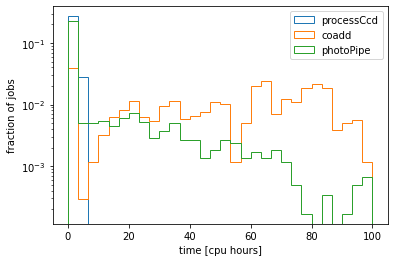

In [73]:
plt.hist(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED')],
         range=[0,100],bins=30,density=True,label='processCcd',histtype='step')
plt.hist(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED')],
         range=[0,100],bins=30,density=True,label='coadd',histtype='step')
plt.hist(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED')],
         range=[0,100],bins=30,density=True,label='photoPipe',histtype='step')
plt.xlabel('time [cpu hours]')
plt.legend()
plt.ylabel('fraction of jobs')
plt.yscale('log')
plt.savefig('./figs/job_times_hist.pdf', bbox_inches='tight')
plt.savefig('./figs/job_times_hist.png', bbox_inches='tight')